Mostly coppied from https://github.com/lsst/rubin_scheduler/blob/main/rubin_scheduler/scheduler/surveys/ddf_presched.py

Using `rubin_scheduler`, should be able to install everything needed with:

    conda install -c conda-forge rubin-scheduler
    scheduler_download_data

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import os

from rubin_scheduler.data import get_data_dir
from rubin_scheduler.scheduler.utils import scheduled_observation
from rubin_scheduler.utils import calc_season, ddf_locations, survey_start_mjd
from rubin_scheduler.site_models import Almanac

from scipy.stats import binned_statistic

In [2]:
# Data file containing handy depths over time for each DDF location. 
# This gets downloaded with the scheduler_download_data command.
data_file = os.path.join(get_data_dir(), "scheduler", "ddf_grid.npz")
ddf_data = np.load(data_file)
ddf_grid = ddf_data["ddf_grid"].copy()
ddf_data.close()

# Load up the locations of the DDFs
ddfs = ddf_locations()
ddfs

{'ELAISS1': (9.45, -44.0),
 'XMM_LSS': (35.708333, -4.75),
 'ECDFS': (53.125, -28.1),
 'COSMOS': (150.1, 2.1819444444444445),
 'EDFS_a': (58.9, -49.315),
 'EDFS_b': (63.6, -47.6)}

In [3]:
# Can see the grid has MJD, and then airmass, sky brightness, amd g-band 5-sigma limiting depth per ddf
# Note the depth is assuming some nominal constant seeing (probably 0.7 arcsec at zenith)
# Also the sun altitude at each timestep, as well as the next sunrise twilight start.
ddf_grid.dtype

dtype([('mjd', '<f8'), ('sun_alt', '<f8'), ('sun_n18_rising_next', '<f8'), ('ELAISS1_airmass', '<f8'), ('ELAISS1_sky_g', '<f8'), ('ELAISS1_m5_g', '<f8'), ('XMM_LSS_airmass', '<f8'), ('XMM_LSS_sky_g', '<f8'), ('XMM_LSS_m5_g', '<f8'), ('ECDFS_airmass', '<f8'), ('ECDFS_sky_g', '<f8'), ('ECDFS_m5_g', '<f8'), ('COSMOS_airmass', '<f8'), ('COSMOS_sky_g', '<f8'), ('COSMOS_m5_g', '<f8'), ('EDFS_a_airmass', '<f8'), ('EDFS_a_sky_g', '<f8'), ('EDFS_a_m5_g', '<f8'), ('EDFS_b_airmass', '<f8'), ('EDFS_b_sky_g', '<f8'), ('EDFS_b_m5_g', '<f8')])

Text(0, 0.5, '5-sigma depth in g')

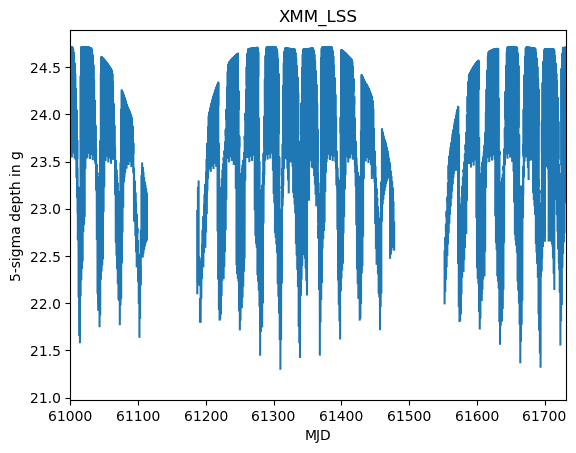

In [4]:
# Let's look at the depths over time for one DDF
ddf_name = "XMM_LSS"
fig, ax = plt.subplots()

ax.plot(ddf_grid["mjd"], ddf_grid["%s_m5_g" % ddf_name])
ax.set_xlim([61000, 61732])
ax.set_xlabel("MJD")
ax.set_title(ddf_name)
ax.set_ylabel('5-sigma depth in g')

In [5]:
# assign an integer night to each MJD value
almanac = Almanac(mjd_start=survey_start_mjd())
almanac_indx = almanac.mjd_indx(ddf_grid["mjd"])
night = almanac.sunsets["night"][almanac_indx]

# Let's cut down the DDF array to only be 10 years long
indx = np.where((night < 3652) & (night >= 0))
night = night[indx]
ddf_grid = ddf_grid[indx]

# Let's say we want to observe every-other night where the depth is
# above some floor.
m5_limit = 24.
bins = np.arange(np.min(night), np.max(night)+2, 1) - 0.5
finite_indx = np.isfinite(ddf_grid["%s_m5_g" % ddf_name])
deepest_per_night, bin_edges, bin_n = binned_statistic(night[finite_indx],
                                                       ddf_grid["%s_m5_g" % ddf_name][finite_indx],
                                                       statistic=np.nanmax,
                                                       bins=bins)
binned_night = (bin_edges[0:-1] + bin_edges[1:])/2
nights_flag = np.zeros(binned_night.size)
# Loop over each night. If we meet the depth limit, and didn't observe 
# the previous night, mark it as a night to do a sequence
for i in np.arange(binned_night.size-1)+1:
    if (nights_flag[i-1] == 0) & (deepest_per_night[i] > m5_limit):
        nights_flag[i] = 1

nights_to_observe = binned_night[np.where(nights_flag == 1)]

# Could replace the above with any sort of logic you want for which nights 
# You want to observe a DDF


In [6]:

# Some basic limits.  See help(scheduled_observation) for details on these
flush_length = 2. # Days
expt = 30.  # Seconds
mjd_tol = 0.1 # Days
dist_tol = np.radians(2.)
HA_min = 21.  # Hour angle limits
HA_max = 3.
alt_min = np.radians(25.)
alt_max = np.radians(85.)
sun_alt_max = np.radians(-18.)

# How many visits to take in each filter
sequence = {'u':8, 'g': 10, 'r': 20, 'i': 20, 'z': 24, 'y': 18}
# number of snaps per visit
nsnaps = {'u':1, 'g': 1, 'r': 1, 'i': 1, 'z': 1, 'y': 1}

# now to loop over each night and generate a sequence of scheduled observations
final_observations_list = []
for obs_night in nights_to_observe:
    in_night = np.where((night == obs_night) & (np.isfinite(ddf_grid["%s_m5_g" % ddf_name]) == True))[0]
    # find the best time in the night to launch the DDF
    # This could be made more sophisticated, e.g., check there's enough time to do the sequence,
    # or inerpolate to the best time rather than using the nearest timestep, etc.
    indx = np.min(np.where(ddf_grid["%s_m5_g" % ddf_name][in_night] == np.max(ddf_grid["%s_m5_g" % ddf_name][in_night])))
    mjd = ddf_grid["mjd"][in_night[indx]]
    
    for filtername in sequence:
        for i in np.arange(sequence[filtername]):
            # Make a new empty observation
            obs = scheduled_observation()
            # fill in all the relevant info for it
            obs["RA"] = np.radians(ddfs[ddf_name][0])
            obs["dec"] = np.radians(ddfs[ddf_name][1])
            obs["mjd"] = mjd
            obs["flush_by_mjd"] = mjd + flush_length
            obs["exptime"] = expt
            obs["filter"] = filtername
            obs["nexp"] = nsnaps[filtername]
            obs["note"] = "DD:%s" % ddf_name
            obs["target"] = ddf_name

            obs["mjd_tol"] = mjd_tol
            obs["dist_tol"] = dist_tol
            # Need to set something for HA limits
            obs["HA_min"] = HA_min
            obs["HA_max"] = HA_max
            obs["alt_min"] = alt_min
            obs["alt_max"] = alt_max
            obs["sun_alt_max"] = sun_alt_max
            final_observations_list.append(obs)
                        
final_observations = np.concatenate(final_observations_list)
final_observations

array([(0, 0.62322798, -0.08290314, 60848.42916637, 60850.42916637, 30., 'u', 0., 0., 0., 0., 1, 'DD:XMM_LSS', 'XMM_LSS', 0.1, 0.03490659, 0.43633231, 1.48352986, 3., 21., -0.31415927, False, 0),
       (0, 0.62322798, -0.08290314, 60848.42916637, 60850.42916637, 30., 'u', 0., 0., 0., 0., 1, 'DD:XMM_LSS', 'XMM_LSS', 0.1, 0.03490659, 0.43633231, 1.48352986, 3., 21., -0.31415927, False, 0),
       (0, 0.62322798, -0.08290314, 60848.42916637, 60850.42916637, 30., 'u', 0., 0., 0., 0., 1, 'DD:XMM_LSS', 'XMM_LSS', 0.1, 0.03490659, 0.43633231, 1.48352986, 3., 21., -0.31415927, False, 0),
       ...,
       (0, 0.62322798, -0.08290314, 64369.04374888, 64371.04374888, 30., 'y', 0., 0., 0., 0., 1, 'DD:XMM_LSS', 'XMM_LSS', 0.1, 0.03490659, 0.43633231, 1.48352986, 3., 21., -0.31415927, False, 0),
       (0, 0.62322798, -0.08290314, 64369.04374888, 64371.04374888, 30., 'y', 0., 0., 0., 0., 1, 'DD:XMM_LSS', 'XMM_LSS', 0.1, 0.03490659, 0.43633231, 1.48352986, 3., 21., -0.31415927, False, 0),
       (

This array can be passed into the scheduler and simulated.

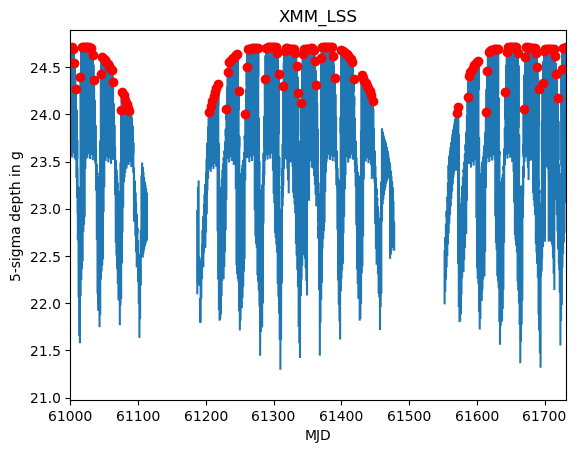

In [7]:
# Let's plot up where the final scheduled results actually landed:
final_mjd = np.unique(final_observations["mjd"])
depths = np.interp(final_mjd, ddf_grid["mjd"], ddf_grid["%s_m5_g" % ddf_name])

fig, ax = plt.subplots()

ax.plot(ddf_grid["mjd"], ddf_grid["%s_m5_g" % ddf_name])
ax.set_xlim([61000, 61732])
ax.set_xlabel("MJD")
ax.set_title(ddf_name)
ax.set_ylabel('5-sigma depth in g')

ax.plot(final_mjd, depths, 'ro')

In [8]:
help(scheduled_observation)

Help on function scheduled_observation in module rubin_scheduler.scheduler.utils.utils:

scheduled_observation(n=1)
    Make an array to hold pre-scheduling observations
    
    Returns
    -------
    result : np.array
    
    
    Note
    ----
    mjd_tol : `float`
        The tolerance on how early an observation can execute (days).
        Observation will be considered valid to attempt
        when mjd-mjd_tol < current MJD < flush_by_mjd (and other conditions below pass)
    dist_tol : `float`
        The angular distance an observation can be away from the specified RA,Dec and
        still count as completing the observation (radians).
    alt_min : `float`
        The minimum altitude to consider executing the observation (radians).
    alt_max : `float`
        The maximuim altitude to try observing (radians).
    HA_max : `float`
        Hour angle limit. Constraint is such that for hour angle running from 0 to 24 hours,
        the target RA,Dec must be greather than HA_

# How the baseline scheduler generates the DDF array

In [9]:
def optimize_ddf_times(
    ddf_name,
    ddf_RA,
    ddf_grid,
    sun_limit=-18,
    sequence_time=60.0,
    airmass_limit=2.5,
    sky_limit=None,
    g_depth_limit=23.5,
    season_unobs_frac=0.1,
):
    """

    Parameters
    ----------
    ddf : `str`
        The name of the DDF
    ddf_grid : `np.array`
        An array with info for the DDFs. Generated by the
        rubin_scheduler.scheduler/surveys/generate_ddf_grid.py` script
    season_unobs_frac : `float`
        7.2 month observing season if season_unobs_frac = 0.2 (shaves 20% off
        each end of the full year)
    sequence_time : `float`
        How long a sequence is expected to be (minutes). Used to make
        sure things are not scheduled too close to twilight.
    """
    sun_limit = np.radians(sun_limit)
    sequence_time = sequence_time / 60.0 / 24.0  # to days

    # XXX-- double check that I got this right
    almanac = Almanac(mjd_start=ddf_grid["mjd"].min())

    almanac_indx = almanac.mjd_indx(ddf_grid["mjd"])
    night = almanac.sunsets["night"][almanac_indx]
    ngrid = ddf_grid["mjd"].size

    # set a sun, airmass, sky masks
    sun_mask = np.ones(ngrid, dtype=int)
    sun_mask[np.where(ddf_grid["sun_alt"] >= sun_limit)] = 0

    # expand sun mask backwards by the sequence time.
    n_back = np.ceil(sequence_time / (ddf_grid["mjd"][1] - ddf_grid["mjd"][0])).astype(int)
    shadow_indx = np.where(sun_mask == 0)[0] - n_back
    shadow_indx = shadow_indx[np.where(shadow_indx >= 0)]

    sun_mask[shadow_indx] = 0

    airmass_mask = np.ones(ngrid, dtype=int)
    airmass_mask[np.where(ddf_grid["%s_airmass" % ddf_name] >= airmass_limit)] = 0

    sky_mask = np.ones(ngrid, dtype=int)
    if sky_limit is not None:
        sky_mask[np.where(ddf_grid["%s_sky_g" % ddf_name] <= sky_limit)] = 0
        sky_mask[np.where(np.isnan(ddf_grid["%s_sky_g" % ddf_name]) == True)] = 0

    m5_mask = np.zeros(ngrid, dtype=bool)
    m5_mask[np.isfinite(ddf_grid["%s_m5_g" % ddf_name])] = 1

    if g_depth_limit is not None:
        m5_mask[np.where(ddf_grid["%s_m5_g" % ddf_name] < g_depth_limit)] = 0

    big_mask = sun_mask * airmass_mask * sky_mask * m5_mask

    potential_nights = np.unique(night[np.where(big_mask > 0)])

    # prevent a repeat sequence in a night
    unights, indx = np.unique(night, return_index=True)
    night_mjd = ddf_grid["mjd"][indx]
    # The season of each night
    night_season = calc_season(ddf_RA, night_mjd)

    raw_obs = np.ones(unights.size)
    # take out the ones that are out of season
    season_mod = night_season % 1

    out_season = np.where((season_mod < season_unobs_frac) | (season_mod > (1.0 - season_unobs_frac)))
    raw_obs[out_season] = 0

    cumulative_desired = ddf_slopes(ddf_name, raw_obs, night_season)

    night_mask = unights * 0
    night_mask[potential_nights] = 1

    unight_sched = match_cumulative(cumulative_desired, mask=night_mask)
    cumulative_sched = np.cumsum(unight_sched)

    nights_to_use = unights[np.where(unight_sched == 1)]

    # For each night, find the best time in the night.
    # XXX--probably need to expand this part to resolve the times when multiple things get scheduled
    mjds = []
    for night_check in nights_to_use:
        in_night = np.where((night == night_check) & (np.isfinite(ddf_grid["%s_m5_g" % ddf_name])))[0]
        m5s = ddf_grid["%s_m5_g" % ddf_name][in_night]
        # we could intorpolate this to get even better than 15 min resolution on when to observe
        max_indx = np.where(m5s == m5s.max())[0].min()
        mjds.append(ddf_grid["mjd"][in_night[max_indx]])

    return mjds, night_mjd, cumulative_desired, cumulative_sched


In [10]:
def ddf_slopes(ddf_name, raw_obs, night_season):
    """
    Let's make custom slopes for each DDF

    Parameters
    ----------
    ddf_name : str
       The DDF name to use
    raw_obs : np.array
        An array with values of 1 or zero. One element per night, value of
        1 indicates the night is during an active observing season.
    night_season : np.array
        An array of floats with the fractional season value
        (e.g., 0.5 would be half way through the first season)
    """

    # OK, so 258 sequences is ~1% of the survey
    # so a 25.8 sequences is a 0.1% season
    # COSMOS is going to be 0.7% for 3 years, then 0.175 for the rest.

    ss = 30  # standard season, was 45

    if (ddf_name == "ELAISS1") | (ddf_name == "XMM_LSS") | (ddf_name == "ECDFS"):
        # Dict with keys for each season and values of the number of sequences
        # to attempt.
        season_vals = {
            0: 10,
            1: ss,
            2: ss,
            3: ss,
            4: ss,
            5: ss,
            6: ss,
            7: ss,
            8: ss,
            9: ss,
            10: 10,
        }

        round_season = np.floor(night_season)

        cumulative_desired = np.zeros(raw_obs.size, dtype=float)
        for season in np.unique(round_season):
            in_season = np.where(round_season == season)
            cumulative = np.cumsum(raw_obs[in_season])
            if cumulative.max() > 0:
                cumulative = cumulative / cumulative.max() * season_vals[season]
                cumulative_desired[in_season] = cumulative + np.max(cumulative_desired)

    if ddf_name == "EDFS_a":
        season_vals = {
            0: 10,
            1: ss,
            2: ss,
            3: ss,
            4: ss,
            5: ss,
            6: ss,
            7: ss,
            8: ss,
            9: ss,
            10: 10,
        }

        round_season = np.floor(night_season)

        cumulative_desired = np.zeros(raw_obs.size, dtype=float)
        for season in np.unique(round_season):
            in_season = np.where(round_season == season)
            cumulative = np.cumsum(raw_obs[in_season])
            if cumulative.max() > 0:
                cumulative = cumulative / cumulative.max() * season_vals[season]
                cumulative_desired[in_season] = cumulative + np.max(cumulative_desired)

    if ddf_name == "COSMOS":
        # looks like COSMOS has no in-season time for 10 at the current start mjd.
        season_vals = {
            0: 10,
            1: ss * 5,
            2: ss * 5,
            3: ss * 2,
            4: ss,
            5: ss,
            6: ss,
            7: ss,
            8: ss,
            9: ss,
            10: 10,
        }

        round_season = np.floor(night_season)

        cumulative_desired = np.zeros(raw_obs.size, dtype=float)
        for season in np.unique(round_season):
            in_season = np.where(round_season == season)[0]
            cumulative = np.cumsum(raw_obs[in_season])
            if cumulative.max() > 0:
                cumulative = cumulative / cumulative.max() * season_vals[season]
                cumulative_desired[in_season] = cumulative + np.max(cumulative_desired)

    return cumulative_desired


In [11]:
def match_cumulative(cumulative_desired, mask=None, no_duplicate=True):
    """Generate a schedule that tries to match the desired cumulative distribution given a mask

    Parameters
    ----------
    cumulative_desired : `np.array`, float
        An array with the cumulative number of desired observations. Elements
        are assumed to be evenly spaced.
    mask : `np.array`, bool or int (None)
        Set to zero for indices that cannot be scheduled
    no_duplicate : `bool` (True)
        If True, only 1 event can be scheduled per element

    Returns
    -------
    schedule : `np.array`
        The resulting schedule, with values marking number of events in that cell.
    """

    rounded_desired = np.round(cumulative_desired)
    sched = cumulative_desired * 0
    if mask is None:
        mask = np.ones(sched.size)

    valid = np.where(mask > 0)[0].tolist()
    x = np.arange(sched.size)

    drd = np.diff(rounded_desired)
    step_points = np.where(drd > 0)[0] + 1

    # would be nice to eliminate this loop, but it's not too bad.
    # can't just use searchsorted on the whole array, because then there
    # can be duplicate values, and array[[n,n]] = 1 means that extra match gets lost.
    for indx in step_points:
        left = np.searchsorted(x[valid], indx)
        right = np.searchsorted(x[valid], indx, side="right")
        d1 = indx - left
        d2 = right - indx
        if d1 < d2:
            sched_at = left
        else:
            sched_at = right

        # If we are off the end
        if sched_at >= len(valid):
            sched_at -= 1

        sched[valid[sched_at]] += 1
        if no_duplicate:
            valid.pop(sched_at)

    return sched


In [12]:
def generate_ddf_scheduled_obs(
    data_file=None,
    flush_length=2,
    mjd_tol=15,
    expt=30.0,
    alt_min=25,
    alt_max=85,
    HA_min=21.0,
    HA_max=3.0,
    sun_alt_max=-18,
    dist_tol=3.0,
    season_unobs_frac=0.1,
    nvis_master=[8, 10, 20, 20, 24, 18],
    filters="ugrizy",
    nsnaps=[1, 2, 2, 2, 2, 2],
    mjd_start=None,
    survey_length=10.0,
    sequence_time=60.0,
):
    """

    Parameters
    ----------
    data_file : `path` (None)
        The data file to use for DDF airmass, m5, etc. Defaults to using whatever is in
        rubin_sim_data/scheduler directory.
    flush_length : `float` (2)
        How long to keep a scheduled observation around before it is considered failed
        and flushed (days).
    mjd_tol : `float` (15)
        How close an observation must be in time to be considered matching a scheduled
        observation (minutes).
    expt : `float` (30)
        Total exposure time per visit (seconds).
    alt_min/max : `float` (25, 85)
        The minimum and maximum altitudes to permit observations to happen (degrees).
    HA_min/max : `float` (21, 3)
        The hour angle limits to permit observations to happen (hours).
    dist_tol : `float` (3)
        The distance tolerance for a visit to be considered matching a scheduled observation
        (degrees).
    season_unobs_frac : `float` (0.1)
        What fraction of the season should the DDF be considered unobservable. Taken off both the
        start and end of the year, so a season frac of 0.1 means 20% of the time the DDF is considered
        unobservable, so it will be in-season for 9.6 months.
    nvis_master : list of ints ([8, 10, 20, 20, 24, 18])
        The number of visits to make per filter
    filters : `str` (ugrizy)
        The filter names.
    nsnaps : `list of ints` ([1, 2, 2, 2, 2, 2])
        The number of snaps to use per filter
    mjd_start : `float`
        Starting MJD of the survey. Default None, which calls rubin_sim.utils.survey_start_mjd
    survey_length : `float`
        Length of survey (years). Default 10.
    """
    if data_file is None:
        data_file = os.path.join(get_data_dir(), "scheduler", "ddf_grid.npz")

    if mjd_start is None:
        mjd_start = survey_start_mjd()

    flush_length = flush_length  # days
    mjd_tol = mjd_tol / 60 / 24.0  # minutes to days
    expt = expt
    alt_min = np.radians(alt_min)
    alt_max = np.radians(alt_max)
    dist_tol = np.radians(dist_tol)
    sun_alt_max = np.radians(sun_alt_max)

    ddfs = ddf_locations()
    ddf_data = np.load(data_file)
    ddf_grid = ddf_data["ddf_grid"].copy()

    mjd_max = mjd_start + survey_length * 365.25

    # check if our pre-computed grid is over the time range we think we are scheduling for
    if (ddf_grid["mjd"].min() > mjd_start) | (ddf_grid["mjd"].max() < mjd_max):
        warnings.warn("Pre-computed DDF properties don't match requested survey times")

    in_range = np.where((ddf_grid["mjd"] >= mjd_start) & (ddf_grid["mjd"] <= mjd_max))
    ddf_grid = ddf_grid[in_range]

    all_scheduled_obs = []
    for ddf_name in ["ELAISS1", "XMM_LSS", "ECDFS", "COSMOS", "EDFS_a"]:
        print("Optimizing %s" % ddf_name)

        # 'ID', 'RA', 'dec', 'mjd', 'flush_by_mjd', 'exptime', 'filter', 'rotSkyPos', 'nexp',
        #         'note'
        # 'mjd_tol', 'dist_tol', 'alt_min', 'alt_max', 'HA_max', 'HA_min', 'observed'
        mjds = optimize_ddf_times(
            ddf_name,
            ddfs[ddf_name][0],
            ddf_grid,
            season_unobs_frac=season_unobs_frac,
            sequence_time=sequence_time,
        )[0]
        for mjd in mjds:
            for filtername, nvis, nexp in zip(filters, nvis_master, nsnaps):
                if "EDFS" in ddf_name:
                    obs = scheduled_observation(n=int(nvis / 2))
                    obs["RA"] = np.radians(ddfs[ddf_name][0])
                    obs["dec"] = np.radians(ddfs[ddf_name][1])
                    obs["mjd"] = mjd
                    obs["flush_by_mjd"] = mjd + flush_length
                    obs["exptime"] = expt
                    obs["filter"] = filtername
                    obs["nexp"] = nexp
                    obs["note"] = "DD:%s" % ddf_name
                    obs["target"] = ddf_name

                    obs["mjd_tol"] = mjd_tol
                    obs["dist_tol"] = dist_tol
                    # Need to set something for HA limits
                    obs["HA_min"] = HA_min
                    obs["HA_max"] = HA_max
                    obs["alt_min"] = alt_min
                    obs["alt_max"] = alt_max
                    obs["sun_alt_max"] = sun_alt_max
                    all_scheduled_obs.append(obs)

                    obs = scheduled_observation(n=int(nvis / 2))
                    obs["RA"] = np.radians(ddfs[ddf_name.replace("_a", "_b")][0])
                    obs["dec"] = np.radians(ddfs[ddf_name.replace("_a", "_b")][1])
                    obs["mjd"] = mjd
                    obs["flush_by_mjd"] = mjd + flush_length
                    obs["exptime"] = expt
                    obs["filter"] = filtername
                    obs["nexp"] = nexp
                    obs["note"] = "DD:%s" % ddf_name.replace("_a", "_b")
                    obs["target"] = ddf_name.replace("_a", "_b")

                    obs["mjd_tol"] = mjd_tol
                    obs["dist_tol"] = dist_tol
                    # Need to set something for HA limits
                    obs["HA_min"] = HA_min
                    obs["HA_max"] = HA_max
                    obs["alt_min"] = alt_min
                    obs["alt_max"] = alt_max
                    obs["sun_alt_max"] = sun_alt_max
                    all_scheduled_obs.append(obs)

                else:
                    obs = scheduled_observation(n=nvis)
                    obs["RA"] = np.radians(ddfs[ddf_name][0])
                    obs["dec"] = np.radians(ddfs[ddf_name][1])
                    obs["mjd"] = mjd
                    obs["flush_by_mjd"] = mjd + flush_length
                    obs["exptime"] = expt
                    obs["filter"] = filtername
                    obs["nexp"] = nexp
                    obs["note"] = "DD:%s" % ddf_name
                    obs["target"] = ddf_name

                    obs["mjd_tol"] = mjd_tol
                    obs["dist_tol"] = dist_tol
                    # Need to set something for HA limits
                    obs["HA_min"] = HA_min
                    obs["HA_max"] = HA_max
                    obs["alt_min"] = alt_min
                    obs["alt_max"] = alt_max
                    obs["sun_alt_max"] = sun_alt_max
                    all_scheduled_obs.append(obs)

    result = np.concatenate(all_scheduled_obs)
    # Put in the scripted ID so it's easier to track which ones fail.
    result["scripted_id"] = np.arange(result.size)
    return result


In [13]:
baseline_script = generate_ddf_scheduled_obs()

Optimizing ELAISS1
Optimizing XMM_LSS
Optimizing ECDFS
Optimizing COSMOS
Optimizing EDFS_a


In [14]:
baseline_script

array([(0, 0.16493361, -0.76794487, 60820.41874971, 60822.41874971, 30., 'u', 0., 0., 0., 0., 1, 'DD:ELAISS1', 'ELAISS1', 0.01041667, 0.05235988, 0.43633231, 1.48352986, 3., 21., -0.31415927, False,      0),
       (0, 0.16493361, -0.76794487, 60820.41874971, 60822.41874971, 30., 'u', 0., 0., 0., 0., 1, 'DD:ELAISS1', 'ELAISS1', 0.01041667, 0.05235988, 0.43633231, 1.48352986, 3., 21., -0.31415927, False,      1),
       (0, 0.16493361, -0.76794487, 60820.41874971, 60822.41874971, 30., 'u', 0., 0., 0., 0., 1, 'DD:ELAISS1', 'ELAISS1', 0.01041667, 0.05235988, 0.43633231, 1.48352986, 3., 21., -0.31415927, False,      2),
       ...,
       (0, 1.1100294 , -0.83077672, 64421.0020822 , 64423.0020822 , 30., 'y', 0., 0., 0., 0., 2, 'DD:EDFS_b', 'EDFS_b', 0.01041667, 0.05235988, 0.43633231, 1.48352986, 3., 21., -0.31415927, False, 167997),
       (0, 1.1100294 , -0.83077672, 64421.0020822 , 64423.0020822 , 30., 'y', 0., 0., 0., 0., 2, 'DD:EDFS_b', 'EDFS_b', 0.01041667, 0.05235988, 0.43633231, 1.

This array then gets loaded into a `ScriptedSurvey` object, which can then include additional spatial and rotational dithering commands and rules for avoiding wind.